In [71]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [72]:
(train,test), info = tfds.load('stanford_dogs', split=['train', 'test'], with_info=True)

In [73]:
def load_and_preprocess_dataset(train_size, test_size):
    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs', 
        split=['train', 'test'], 
        with_info=True,
        as_supervised=True
    )

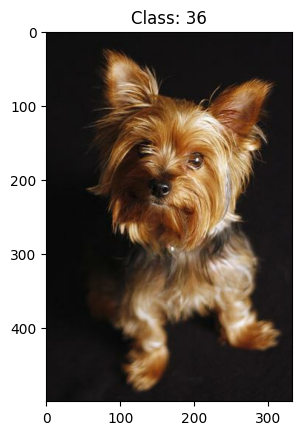

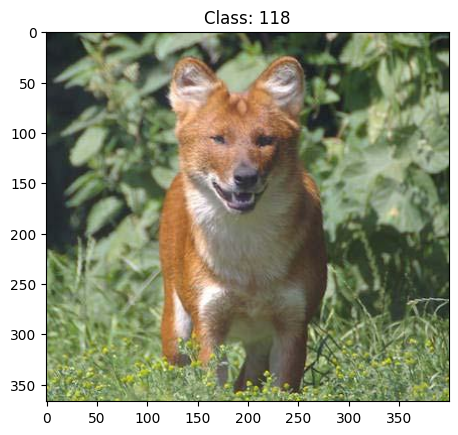

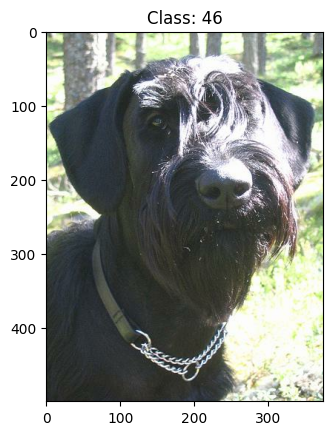

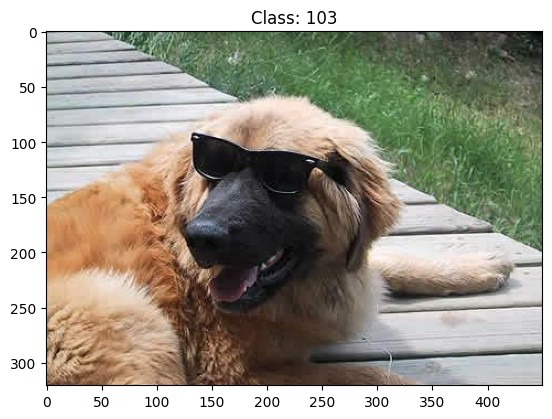

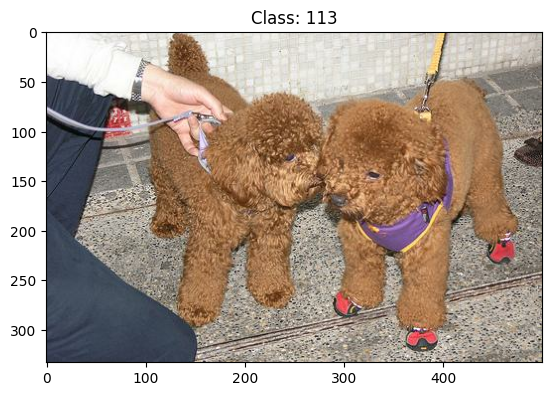

In [74]:
def load_and_preprocess_dataset(train_size, test_size):
    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True
    )
    for image, label in train_dataset.take(5):
        plt.figure()
        plt.imshow(image)
        plt.title(f"Class: {label.numpy()}")
        plt.show()

train_size = 100
test_size = 20

load_and_preprocess_dataset(train_size, test_size)

In [75]:
def load_and_preprocess_dataset(train_size, test_size):

    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True,
        download = True
    )

    def preprocess(image, label):
        image = tf.image.resize(image, (28,28))
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    train_dataset = train_dataset.take(train_size)
    test_dataset = test_dataset.take(test_size)

    X_train, y_train = [], []
    for image, label in tfds.as_numpy(train_dataset):
        X_train.append(image)
        y_train.append(label)

    X_test, y_test = [], []
    for image, label in tfds.as_numpy(test_dataset):
        X_test.append(image)
        y_test.append(label)

    # Reshape and convert lists to numpy arrays
    X_train = np.array(X_train).reshape(-1, 28 * 28 * 3)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 28 * 28 * 3)
    y_test = np.array(y_test).reshape(-1, 1)

    # Scaling
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    # One-hot encoding
    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)

    return X_train, X_test, y_train, y_test

In [76]:
X_train, X_test, y_train, y_test = load_and_preprocess_dataset(12000,8580)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (12000, 2352)
y_train: (12000, 120)
X_test: (8580, 2352)
y_test: (8580, 120)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [77]:
X_train.shape

(12000, 2352)

In [78]:
X_test.shape

(8580, 2352)

In [79]:
X_train = X_train.reshape(X_train.shape[0],28,28,3)
X_test = X_test.reshape(X_test.shape[0],28,28,3)

In [80]:
def simple_model(initializer, activation='relu'):
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(28,28,3), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(120, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_normal())
    ])

In [81]:
alexnet_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(48,(3,3), activation='relu', padding='same', input_shape=(28,28,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5), #after every Dense layer we add. add dropout layer to randomly drop
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax') #120 for categories, end with softmax
])

In [82]:
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 28, 28, 48)        1344      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 128)       55424     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 7, 7, 192)         221376    
                                                                 
 conv2d_46 (Conv2D)          (None, 7, 7, 192)       

In [83]:
alexnet_history = alexnet_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7912 - accuracy: 0.0069 - val_loss: 4.7872 - val_accuracy: 0.0080
Epoch 2/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7888 - accuracy: 0.0068 - val_loss: 4.7872 - val_accuracy: 0.0061
Epoch 3/10
375/375 [==============================] - 15s 41ms/step - loss: 4.7885 - accuracy: 0.0067 - val_loss: 4.7872 - val_accuracy: 0.0080
Epoch 4/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7884 - accuracy: 0.0051 - val_loss: 4.7874 - val_accuracy: 0.0080
Epoch 5/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7884 - accuracy: 0.0063 - val_loss: 4.7876 - val_accuracy: 0.0070
Epoch 6/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7884 - accuracy: 0.0062 - val_loss: 4.7874 - val_accuracy: 0.0100
Epoch 7/10
375/375 [==============================] - 15s 40ms/step - loss: 4.7884 - accuracy: 0.0071 - val_loss: 4.7875 - val_accuracy:

In [84]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2), #max_pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your. model
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 10 layers because we have 10 categories. Adding the softmax at the end as mentioned before
])

In [85]:
custom_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 1152)            

In [86]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64)

Epoch 1/10
188/188 [==============================] - 3s 12ms/step - loss: 4.6699 - accuracy: 0.0194 - val_loss: 4.5054 - val_accuracy: 0.0307
Epoch 2/10
188/188 [==============================] - 2s 12ms/step - loss: 4.3959 - accuracy: 0.0389 - val_loss: 4.3447 - val_accuracy: 0.0449
Epoch 3/10
188/188 [==============================] - 2s 12ms/step - loss: 4.2408 - accuracy: 0.0546 - val_loss: 4.2723 - val_accuracy: 0.0540
Epoch 4/10
188/188 [==============================] - 2s 12ms/step - loss: 4.0948 - accuracy: 0.0763 - val_loss: 4.2306 - val_accuracy: 0.0674
Epoch 5/10
188/188 [==============================] - 2s 12ms/step - loss: 3.9423 - accuracy: 0.1031 - val_loss: 4.2151 - val_accuracy: 0.0726
Epoch 6/10
188/188 [==============================] - 2s 12ms/step - loss: 3.7712 - accuracy: 0.1243 - val_loss: 4.2402 - val_accuracy: 0.0748
Epoch 7/10
188/188 [==============================] - 2s 12ms/step - loss: 3.5825 - accuracy: 0.1577 - val_loss: 4.2886 - val_accuracy: 0.0744

In [87]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])



In [88]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [89]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64
)


Epoch 1/10
188/188 [==============================] - 4s 19ms/step - loss: 4.6723 - accuracy: 0.0213 - val_loss: 4.5135 - val_accuracy: 0.0348
Epoch 2/10
188/188 [==============================] - 4s 19ms/step - loss: 4.4033 - accuracy: 0.0403 - val_loss: 4.3933 - val_accuracy: 0.0400
Epoch 3/10
188/188 [==============================] - 4s 20ms/step - loss: 4.2177 - accuracy: 0.0625 - val_loss: 4.3117 - val_accuracy: 0.0510
Epoch 4/10
188/188 [==============================] - 4s 19ms/step - loss: 3.9765 - accuracy: 0.1009 - val_loss: 4.3217 - val_accuracy: 0.0554
Epoch 5/10
188/188 [==============================] - 4s 19ms/step - loss: 3.6137 - accuracy: 0.1602 - val_loss: 4.4659 - val_accuracy: 0.0654
Epoch 6/10
188/188 [==============================] - 4s 19ms/step - loss: 3.0450 - accuracy: 0.2679 - val_loss: 4.7268 - val_accuracy: 0.0656
Epoch 7/10
188/188 [==============================] - 4s 19ms/step - loss: 2.2725 - accuracy: 0.4216 - val_loss: 5.4443 - val_accuracy: 0.0641

In [90]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),  # Added Dropout
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),  # Added Dropout
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Added Dropout
    tf.keras.layers.Dense(120, activation='softmax')
])


In [91]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
model_2_history = model_2.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64
)

Epoch 1/10
188/188 [==============================] - 3s 13ms/step - loss: 4.7809 - accuracy: 0.0108 - val_loss: 4.7232 - val_accuracy: 0.0171
Epoch 2/10
188/188 [==============================] - 2s 13ms/step - loss: 4.6360 - accuracy: 0.0208 - val_loss: 4.5235 - val_accuracy: 0.0270
Epoch 3/10
188/188 [==============================] - 3s 13ms/step - loss: 4.5150 - accuracy: 0.0262 - val_loss: 4.4510 - val_accuracy: 0.0352
Epoch 4/10
188/188 [==============================] - 3s 14ms/step - loss: 4.4436 - accuracy: 0.0314 - val_loss: 4.3674 - val_accuracy: 0.0460
Epoch 5/10
188/188 [==============================] - 3s 14ms/step - loss: 4.3853 - accuracy: 0.0368 - val_loss: 4.3230 - val_accuracy: 0.0495
Epoch 6/10
188/188 [==============================] - 2s 12ms/step - loss: 4.3169 - accuracy: 0.0454 - val_loss: 4.3007 - val_accuracy: 0.0514
Epoch 7/10
188/188 [==============================] - 2s 13ms/step - loss: 4.2636 - accuracy: 0.0514 - val_loss: 4.2535 - val_accuracy: 0.0597

In [93]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Additional Conv layer
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Additional Conv layer
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])


In [94]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
model_3_history = model_3.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64
)

Epoch 1/10
188/188 [==============================] - 5s 24ms/step - loss: 4.6791 - accuracy: 0.0202 - val_loss: 4.4963 - val_accuracy: 0.0280
Epoch 2/10
188/188 [==============================] - 4s 23ms/step - loss: 4.3812 - accuracy: 0.0412 - val_loss: 4.3570 - val_accuracy: 0.0432
Epoch 3/10
188/188 [==============================] - 4s 22ms/step - loss: 4.2003 - accuracy: 0.0593 - val_loss: 4.2819 - val_accuracy: 0.0549
Epoch 4/10
188/188 [==============================] - 4s 24ms/step - loss: 4.0229 - accuracy: 0.0887 - val_loss: 4.2311 - val_accuracy: 0.0660
Epoch 5/10
188/188 [==============================] - 4s 23ms/step - loss: 3.8278 - accuracy: 0.1164 - val_loss: 4.2424 - val_accuracy: 0.0734
Epoch 6/10
188/188 [==============================] - 4s 23ms/step - loss: 3.6215 - accuracy: 0.1544 - val_loss: 4.2696 - val_accuracy: 0.0709
Epoch 7/10
188/188 [==============================] - 4s 23ms/step - loss: 3.3835 - accuracy: 0.1954 - val_loss: 4.3531 - val_accuracy: 0.0752

In [96]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [97]:
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [99]:
model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping])


Epoch 1/50
375/375 [==============================] - 5s 13ms/step - loss: 4.7532 - accuracy: 0.0155 - val_loss: 4.6939 - val_accuracy: 0.0217
Epoch 2/50
375/375 [==============================] - 5s 13ms/step - loss: 4.6008 - accuracy: 0.0306 - val_loss: 4.5695 - val_accuracy: 0.0304
Epoch 3/50
375/375 [==============================] - 5s 14ms/step - loss: 4.4116 - accuracy: 0.0483 - val_loss: 4.4364 - val_accuracy: 0.0431
Epoch 4/50
375/375 [==============================] - 5s 13ms/step - loss: 4.2449 - accuracy: 0.0653 - val_loss: 4.3673 - val_accuracy: 0.0565
Epoch 5/50
375/375 [==============================] - 5s 14ms/step - loss: 4.1028 - accuracy: 0.0850 - val_loss: 4.3663 - val_accuracy: 0.0563
Epoch 6/50
375/375 [==============================] - 5s 13ms/step - loss: 3.9709 - accuracy: 0.1106 - val_loss: 4.3500 - val_accuracy: 0.0572
Epoch 7/50
375/375 [==============================] - 5s 13ms/step - loss: 3.8386 - accuracy: 0.1332 - val_loss: 4.3472 - val_accuracy: 0.0621

In [100]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),  # Added Dropout
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),  # Added Dropout
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Added Dropout
    tf.keras.layers.Dense(120, activation='softmax')
])

In [101]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [102]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
model_5_history = model_5.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
188/188 [==============================] - 3s 14ms/step - loss: 4.7555 - accuracy: 0.0117 - val_loss: 4.6597 - val_accuracy: 0.0227
Epoch 2/50
 16/188 [=>............................] - ETA: 2s - loss: 4.6685 - accuracy: 0.0166

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 3s 14ms/step - loss: 4.6128 - accuracy: 0.0223 - val_loss: 4.5373 - val_accuracy: 0.0277
Epoch 3/50
188/188 [==============================] - 2s 13ms/step - loss: 4.4985 - accuracy: 0.0281 - val_loss: 4.4019 - val_accuracy: 0.0367
Epoch 4/50
188/188 [==============================] - 2s 13ms/step - loss: 4.4165 - accuracy: 0.0363 - val_loss: 4.3787 - val_accuracy: 0.0420
Epoch 5/50
188/188 [==============================] - 2s 13ms/step - loss: 4.3537 - accuracy: 0.0397 - val_loss: 4.3080 - val_accuracy: 0.0477
Epoch 6/50
188/188 [==============================] - 2s 13ms/step - loss: 4.2874 - accuracy: 0.0477 - val_loss: 4.2838 - val_accuracy: 0.0526
Epoch 7/50
188/188 [==============================] - 2s 13ms/step - loss: 4.2361 - accuracy: 0.0519 - val_loss: 4.2331 - val_accuracy: 0.0606
Epoch 8/50
188/188 [==============================] - 2s 13ms/step - loss: 4.1779 - accuracy: 0.0629 - val_loss: 4.1845 - val_accuracy: 0.0662
Epoch 9/50

In [104]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Adding dropout with a rate of 0.5
    Dense(120, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
188/188 [==============================] - 3s 14ms/step - loss: 4.7311 - accuracy: 0.0135 - val_loss: 4.5827 - val_accuracy: 0.0251
Epoch 2/50
188/188 [==============================] - 2s 12ms/step - loss: 4.5277 - accuracy: 0.0262 - val_loss: 4.4254 - val_accuracy: 0.0395
Epoch 3/50
188/188 [==============================] - 2s 12ms/step - loss: 4.4075 - accuracy: 0.0362 - val_loss: 4.3654 - val_accuracy: 0.0396
Epoch 4/50
188/188 [==============================] - 2s 12ms/step - loss: 4.3215 - accuracy: 0.0456 - val_loss: 4.2899 - val_accuracy: 0.0519
Epoch 5/50
188/188 [==============================] - 2s 12ms/step - loss: 4.2212 - accuracy: 0.0558 - val_loss: 4.2584 - val_accuracy: 0.0591
Epoch 6/50
188/188 [==============================] - 2s 12ms/step - loss: 4.1437 - accuracy: 0.0671 - val_loss: 4.1818 - val_accuracy: 0.0650
Epoch 7/50
188/188 [==============================] - 2s 12ms/step - loss: 4.0508 - accuracy: 0.0741 - val_loss: 4.1465 - val_accuracy: 0.0648

In [106]:
initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

l2_regularization = 0.01

In [107]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    tf.keras.layers.Dense(120, activation='softmax', kernel_regularizer=regularizers.l2(l2_regularization))
])

model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
model_6_history = model_6.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
188/188 [==============================] - 4s 20ms/step - loss: 5.3112 - accuracy: 0.0180 - val_loss: 4.7490 - val_accuracy: 0.0254
Epoch 2/50
188/188 [==============================] - 4s 19ms/step - loss: 4.6272 - accuracy: 0.0341 - val_loss: 4.5690 - val_accuracy: 0.0339
Epoch 3/50
188/188 [==============================] - 4s 20ms/step - loss: 4.4903 - accuracy: 0.0446 - val_loss: 4.4895 - val_accuracy: 0.0437
Epoch 4/50
188/188 [==============================] - 4s 20ms/step - loss: 4.4015 - accuracy: 0.0547 - val_loss: 4.4717 - val_accuracy: 0.0521
Epoch 5/50
188/188 [==============================] - 4s 20ms/step - loss: 4.3358 - accuracy: 0.0684 - val_loss: 4.4387 - val_accuracy: 0.0554
Epoch 6/50
188/188 [==============================] - 4s 20ms/step - loss: 4.2875 - accuracy: 0.0758 - val_loss: 4.4004 - val_accuracy: 0.0668
Epoch 7/50
188/188 [==============================] - 4s 20ms/step - loss: 4.2332 - accuracy: 0.0835 - val_loss: 4.4214 - val_accuracy: 0.0683